In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
sns.set()

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

def followorbit(vals, path):
    out = []
    for n in range(100):
        closest05 = np.clip(round(path[n] * 2) / 2, 0, 10)
        rank = vals.query(f'nbopp == {n} and othercoop == {closest05}')['rank'].values[0]
        out.append(rank)
    return np.array(out)

import re
def gethighest(vals, prefix="logall_", which=1):
    if which == 1:
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
    else:
        trueval = [int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals]
        itrueval = sorted(list(enumerate(trueval)), key=lambda x: x[1])
        m = itrueval[-which][0]
    return vals[m]

    
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

import platform
hostname = platform.node()
print(hostname)

if hostname == 'cluster':
    prefix = '/home/ecoffet/robocoop/'
else:
    prefix = '/home/pecoffet/remoterobo/'

pecoffet-Precision-Tower-7810


/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_01/rep00/


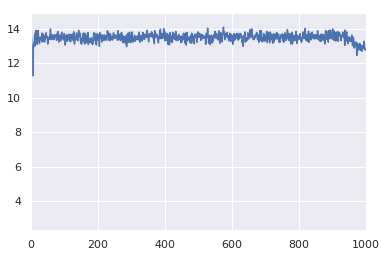

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_01/rep00/analysis_log_49.txt.gz


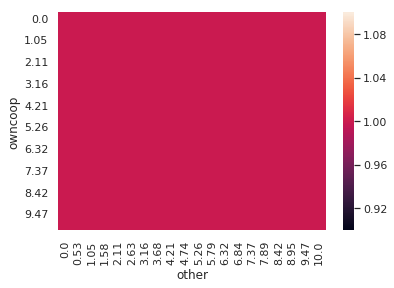

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_01/rep00/analysis_log_999.txt


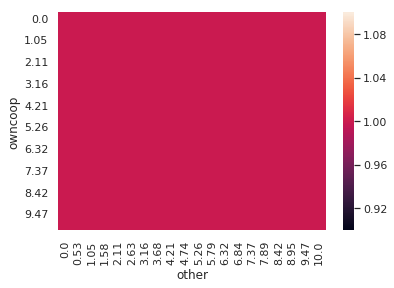

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_02/rep00/


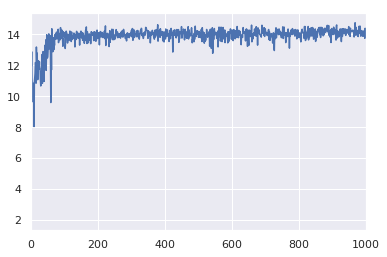

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_02/rep00/analysis_log_49.txt.gz


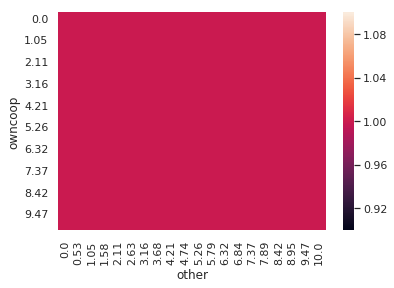

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_02/rep00/analysis_log_999.txt


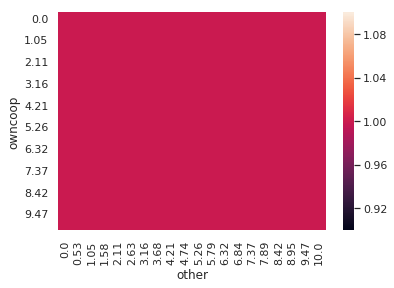

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_03/rep00/


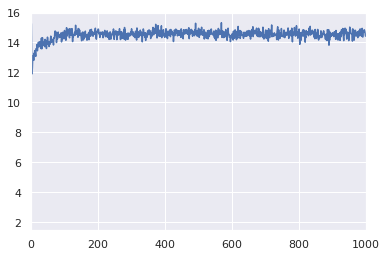

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_03/rep00/analysis_log_49.txt.gz


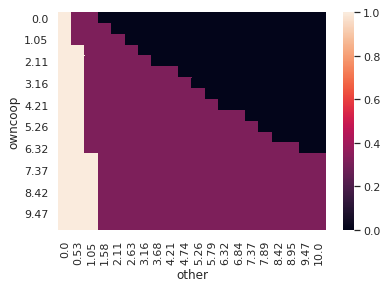

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_03/rep00/analysis_log_999.txt


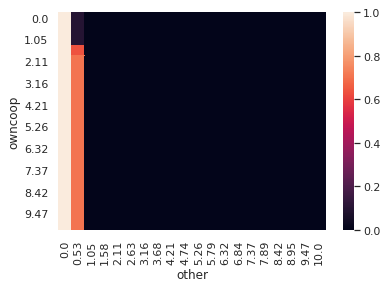

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_04/rep00/


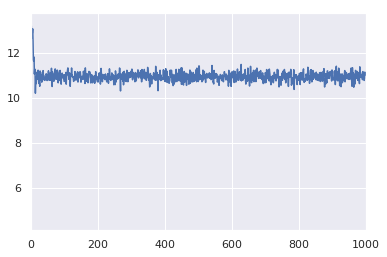

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_04/rep00/analysis_log_49.txt.gz


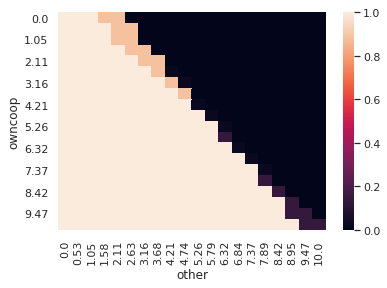

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_04/rep00/analysis_log_999.txt


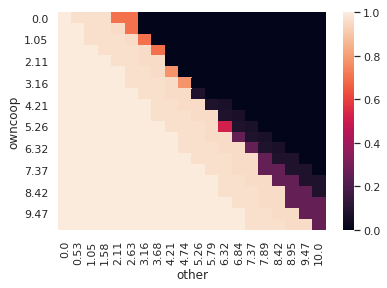

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_05/rep00/


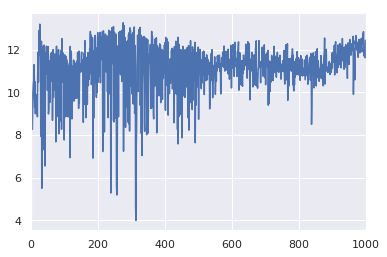

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_05/rep00/analysis_log_999.txt


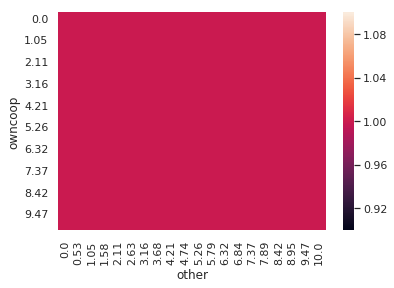

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_06/rep00/


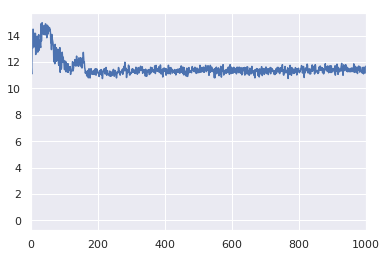

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_06/rep00/analysis_log_49.txt.gz


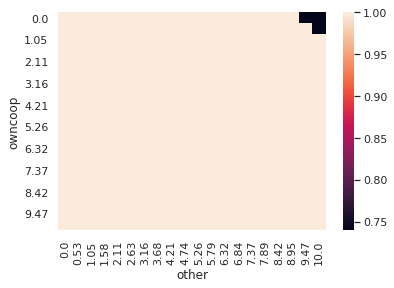

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_06/rep00/analysis_log_999.txt


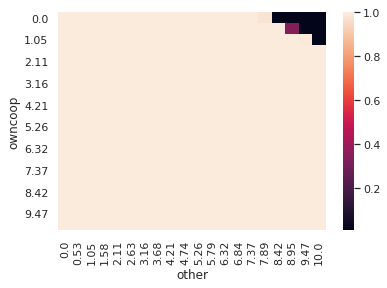

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_07/rep00/


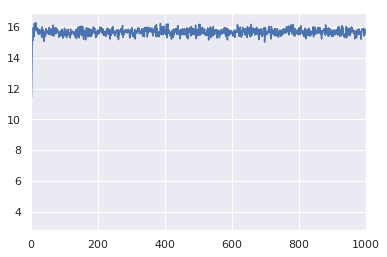

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_07/rep00/analysis_log_49.txt.gz


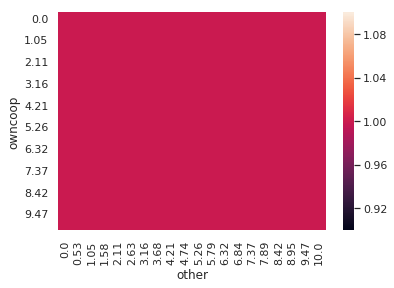

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_07/rep00/analysis_log_999.txt


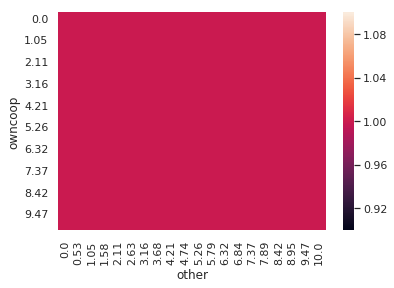

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_08/rep00/


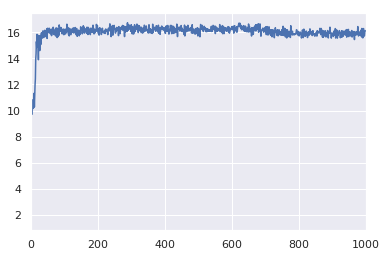

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_08/rep00/analysis_log_49.txt.gz


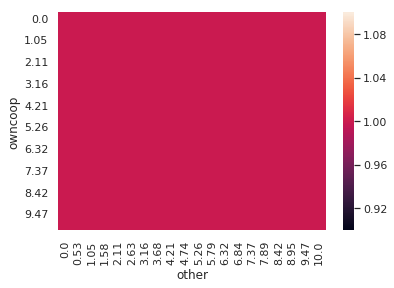

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_08/rep00/analysis_log_999.txt


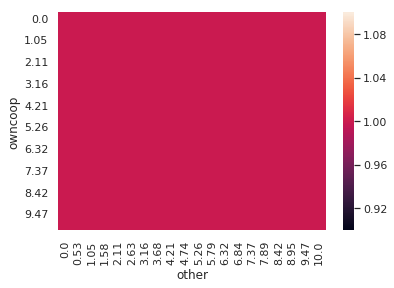

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_09/rep00/


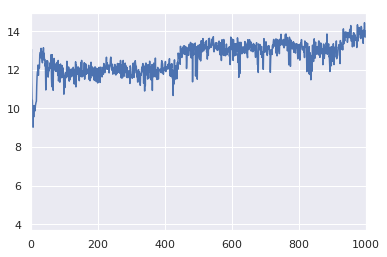

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_09/rep00/analysis_log_49.txt.gz


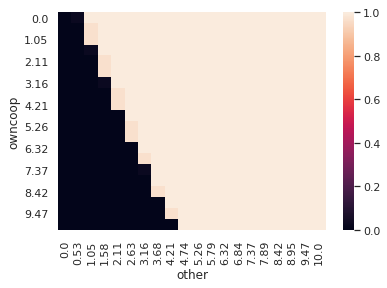

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_09/rep00/analysis_log_999.txt


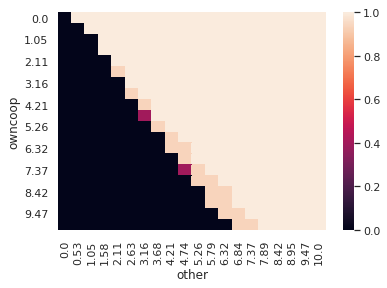

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_10/rep00/


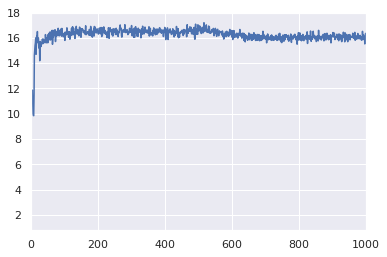

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_10/rep00/analysis_log_49.txt.gz


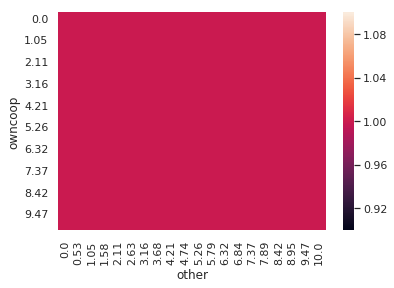

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_10/rep00/analysis_log_999.txt


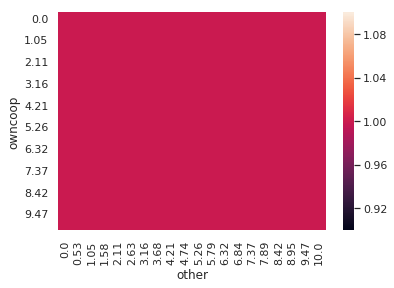

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_11/rep00/


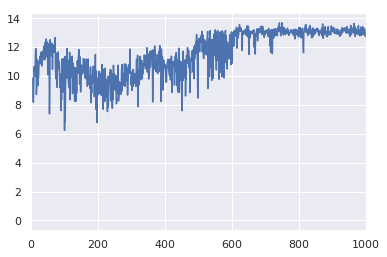

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_11/rep00/analysis_log_49.txt.gz


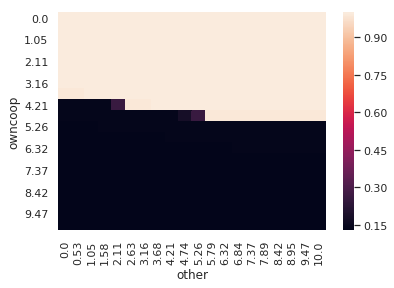

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_11/rep00/analysis_log_999.txt


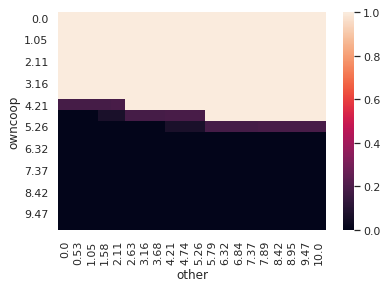

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_12/rep00/


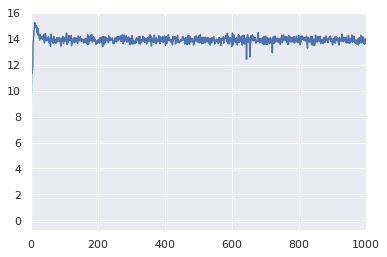

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_12/rep00/analysis_log_49.txt.gz


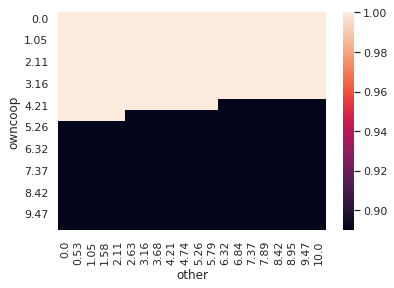

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_12/rep00/analysis_log_999.txt


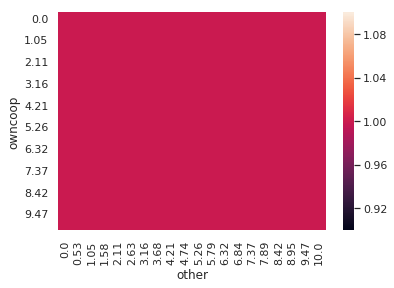

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_13/rep00/


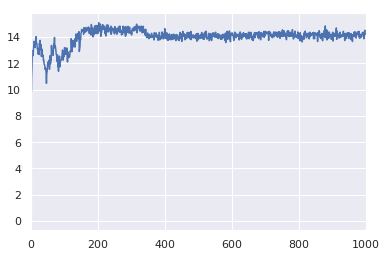

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_13/rep00/analysis_log_49.txt.gz


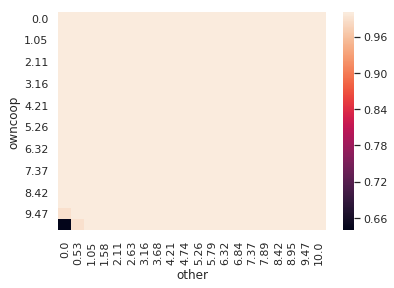

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_13/rep00/analysis_log_999.txt


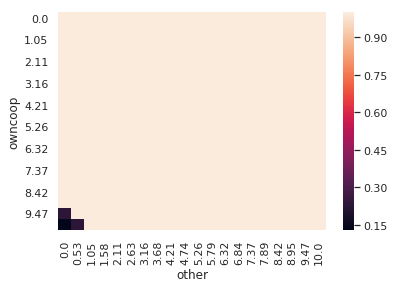

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_14/rep00/


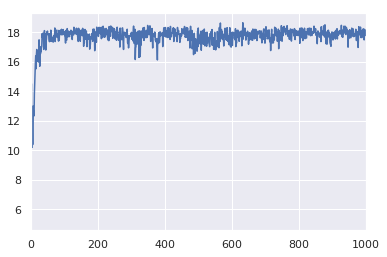

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_14/rep00/analysis_log_49.txt.gz


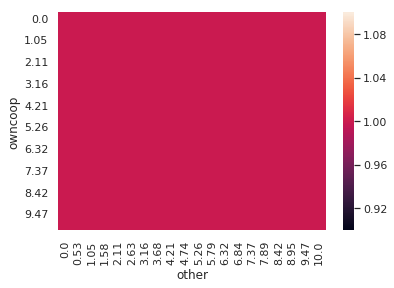

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_14/rep00/analysis_log_999.txt


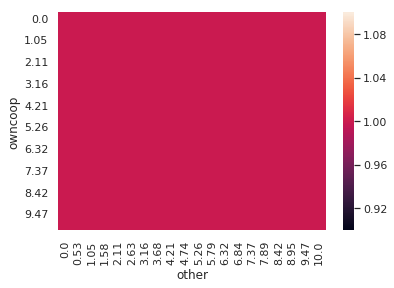

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_15/rep00/


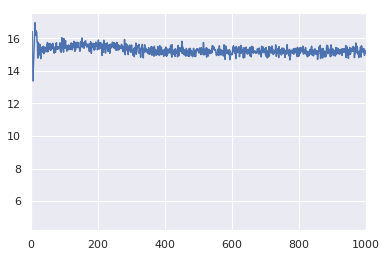

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_15/rep00/analysis_log_49.txt.gz


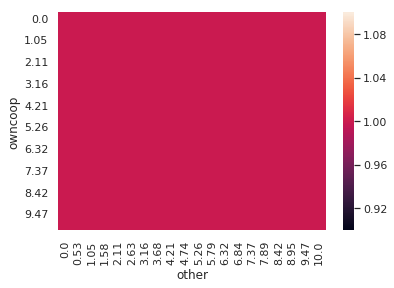

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_15/rep00/analysis_log_999.txt


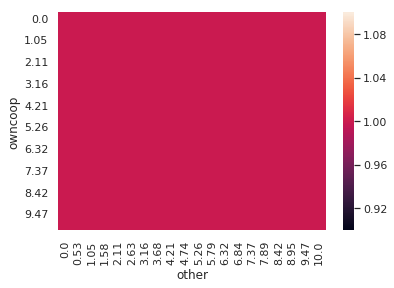

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_16/rep00/


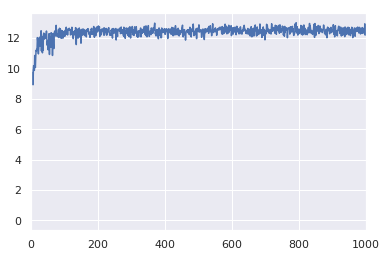

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_16/rep00/analysis_log_999.txt


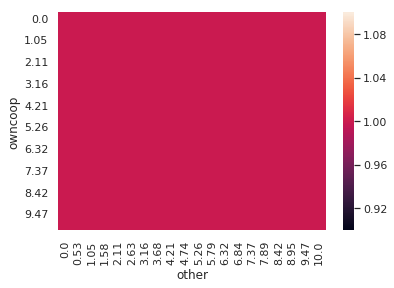

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_17/rep00/


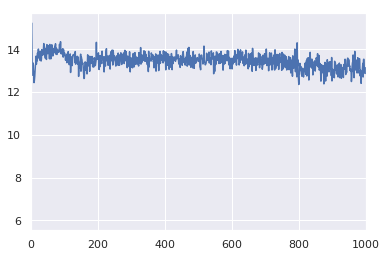

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_17/rep00/analysis_log_99.txt.gz


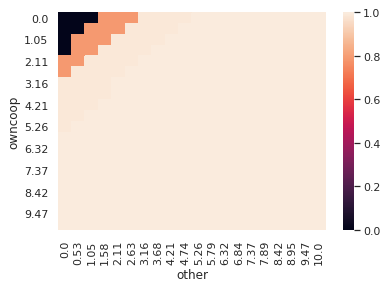

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_17/rep00/analysis_log_999.txt


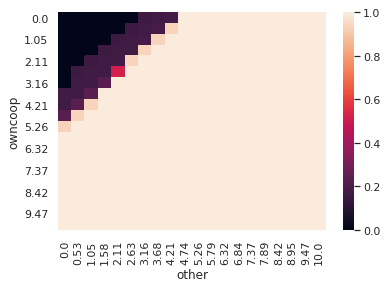

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_18/rep00/


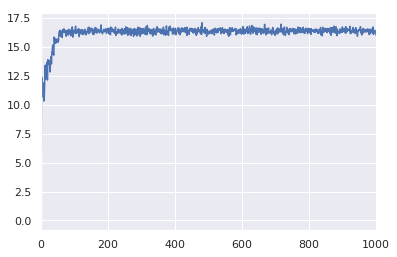

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_18/rep00/analysis_log_999.txt


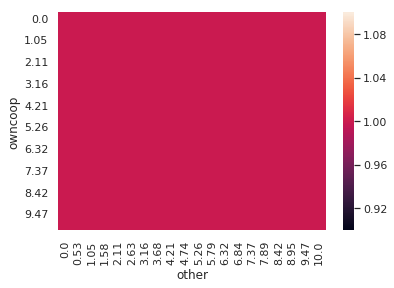

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_19/rep00/


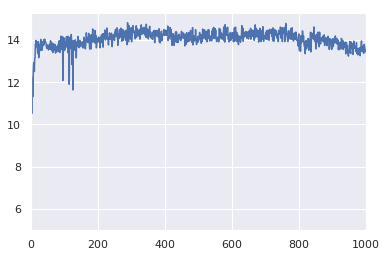

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_19/rep00/analysis_log_49.txt.gz


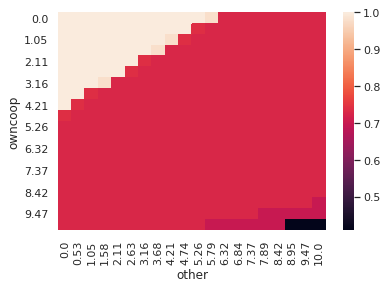

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_19/rep00/analysis_log_999.txt


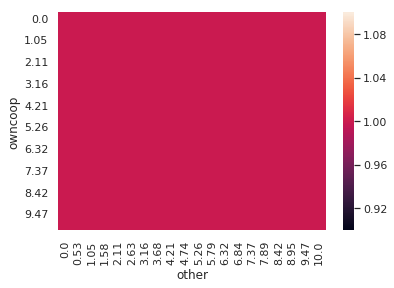

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_20/rep00/


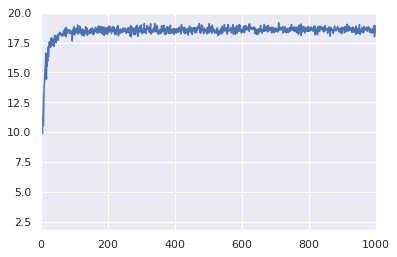

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_20/rep00/analysis_log_49.txt.gz


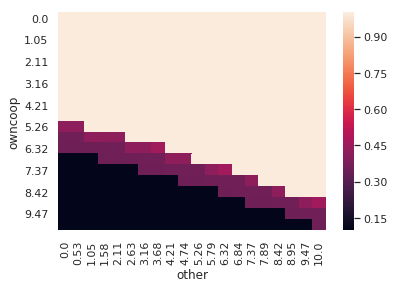

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_20/rep00/analysis_log_999.txt


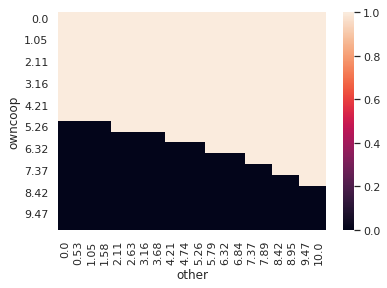

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_21/rep00/


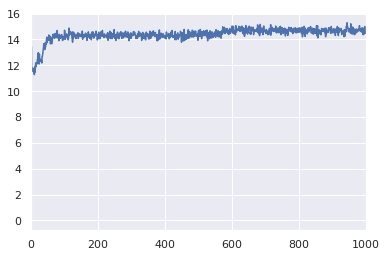

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_21/rep00/analysis_log_49.txt.gz


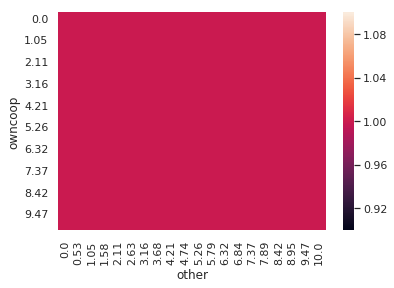

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_21/rep00/analysis_log_999.txt


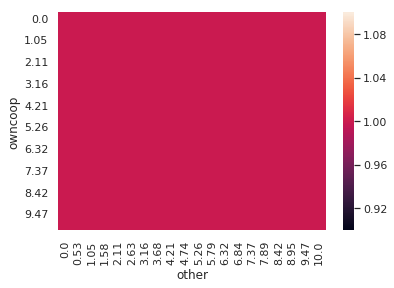

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_22/rep00/


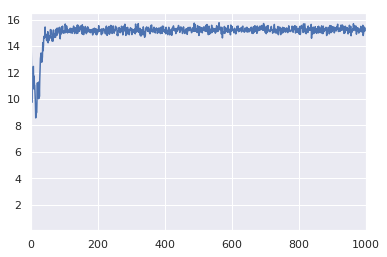

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_22/rep00/analysis_log_49.txt.gz


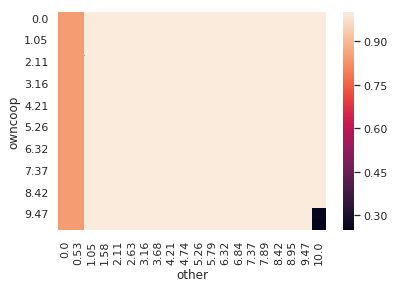

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_22/rep00/analysis_log_999.txt


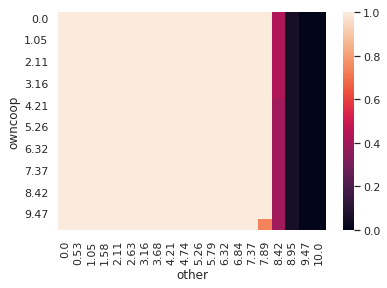

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_23/rep00/


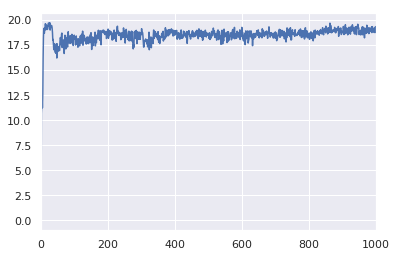

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_23/rep00/analysis_log_49.txt.gz


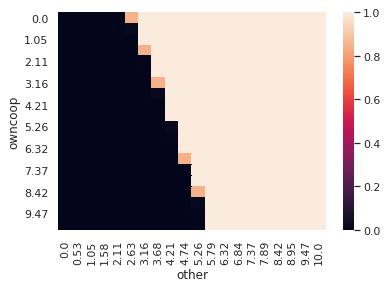

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_23/rep00/analysis_log_999.txt


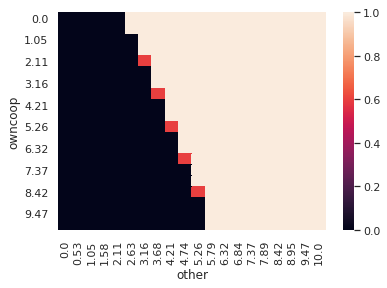

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_24/rep00/


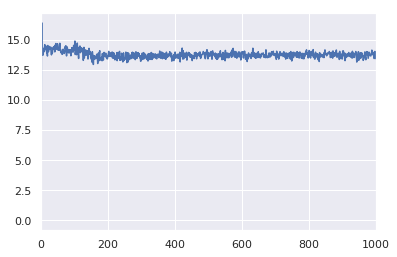

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_24/rep00/analysis_log_49.txt.gz


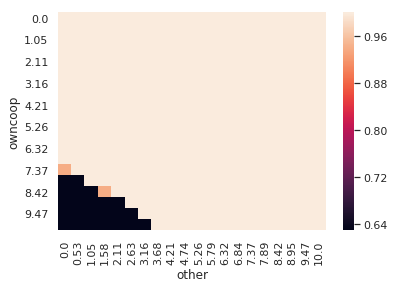

/home/pecoffet/remoterobo//logs/negociate2/negociate-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1539/run_24/rep00/analysis_log_999.txt


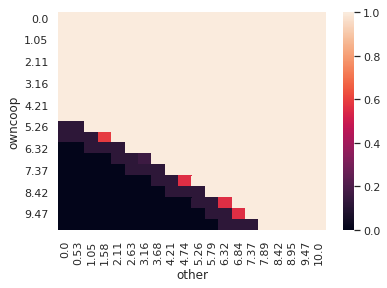

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_01/rep00/


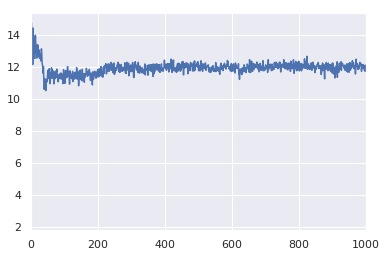

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_01/rep00/analysis_log_49.txt.gz


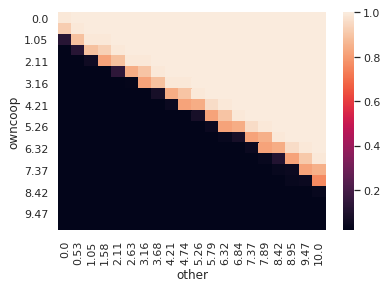

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_01/rep00/analysis_log_999.txt


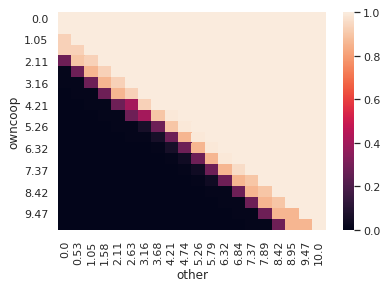

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_02/rep00/


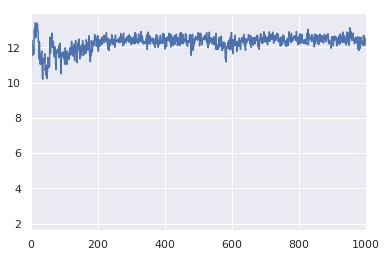

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_02/rep00/analysis_log_49.txt.gz


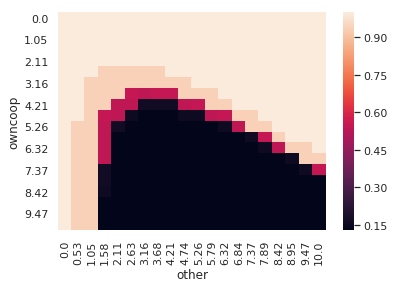

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_02/rep00/analysis_log_999.txt


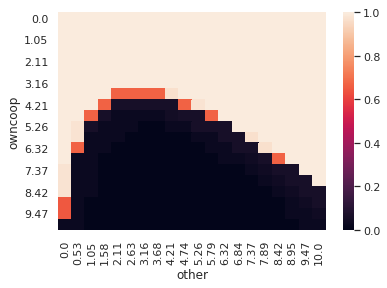

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_03/rep00/


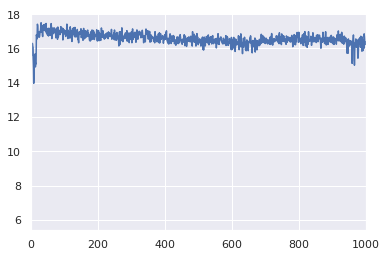

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_03/rep00/analysis_log_99.txt.gz


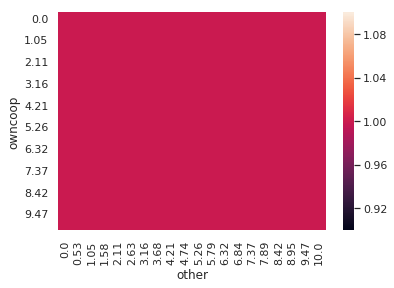

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_03/rep00/analysis_log_999.txt


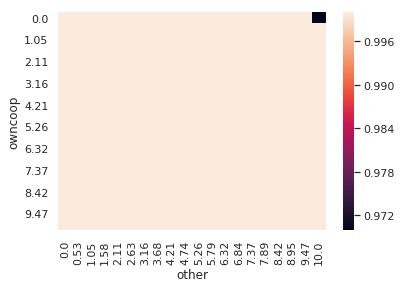

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_04/rep00/


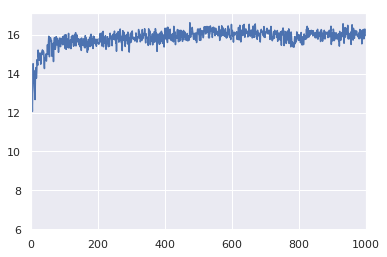

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_04/rep00/analysis_log_49.txt.gz


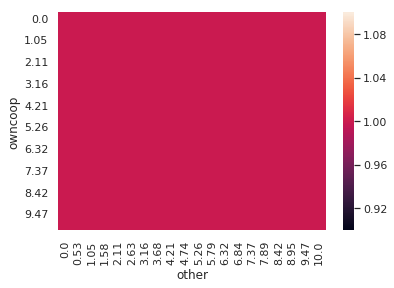

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_04/rep00/analysis_log_999.txt


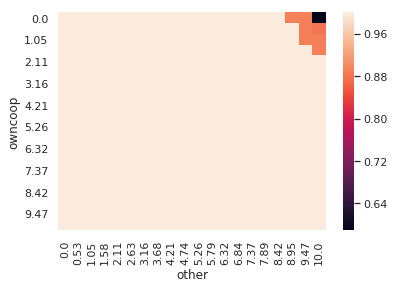

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_05/rep00/


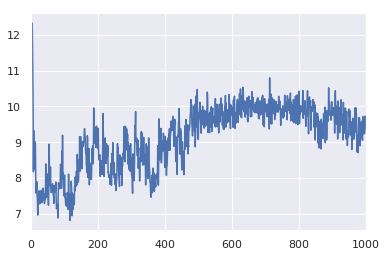

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_05/rep00/analysis_log_999.txt


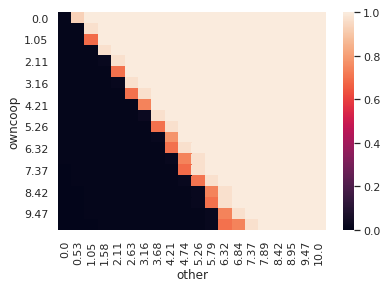

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_06/rep00/


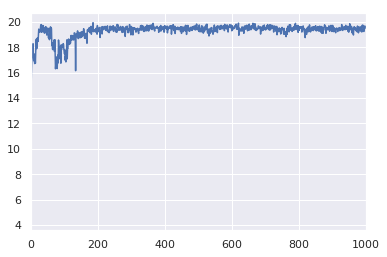

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_06/rep00/analysis_log_49.txt.gz


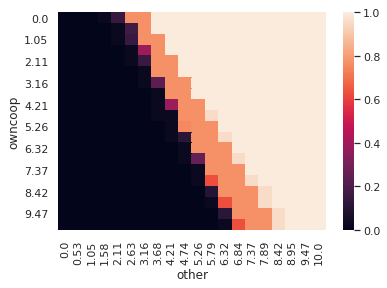

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_06/rep00/analysis_log_999.txt


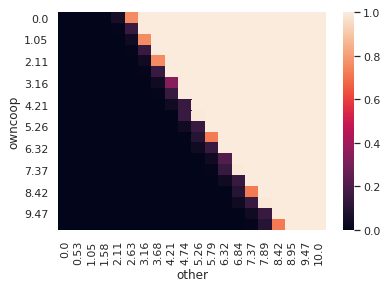

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_07/rep00/


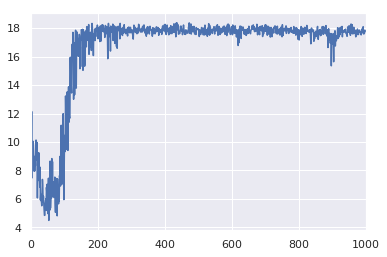

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_07/rep00/analysis_log_999.txt


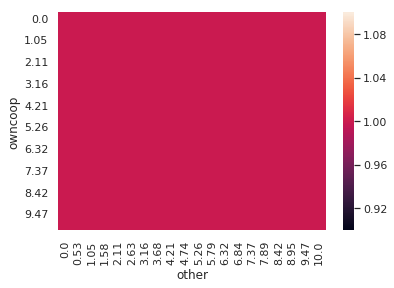

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_08/rep00/


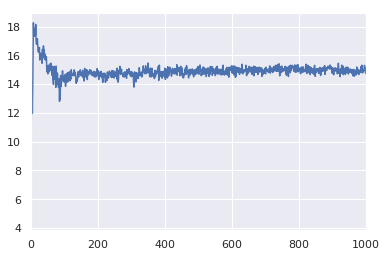

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_08/rep00/analysis_log_49.txt.gz


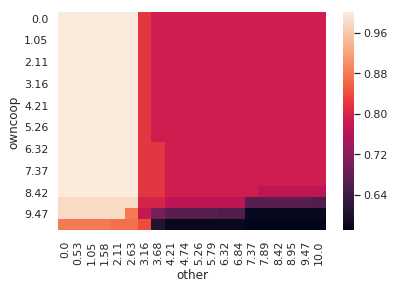

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_08/rep00/analysis_log_999.txt


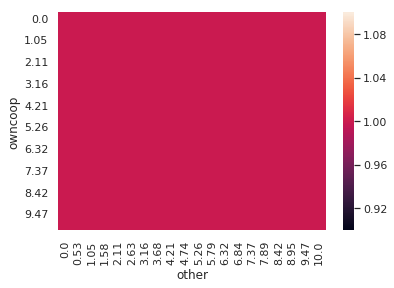

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_09/rep00/


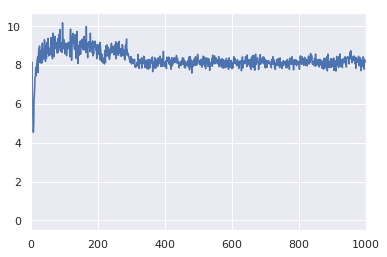

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_09/rep00/analysis_log_49.txt.gz


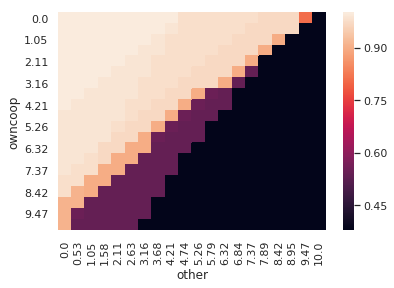

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_09/rep00/analysis_log_999.txt


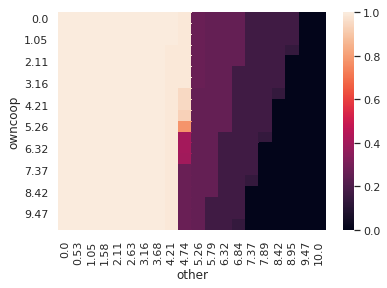

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_10/rep00/


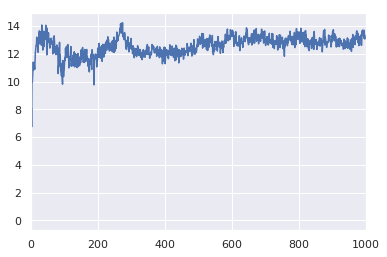

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_10/rep00/analysis_log_999.txt


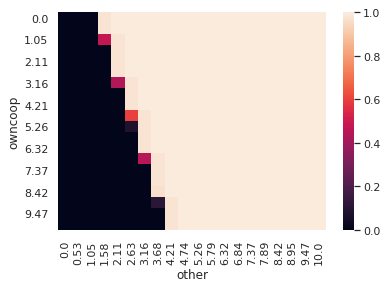

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_11/rep00/


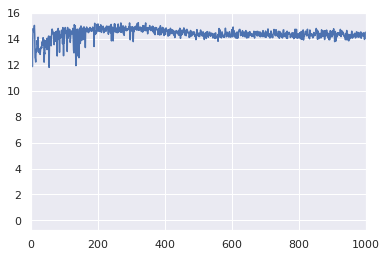

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_11/rep00/analysis_log_49.txt.gz


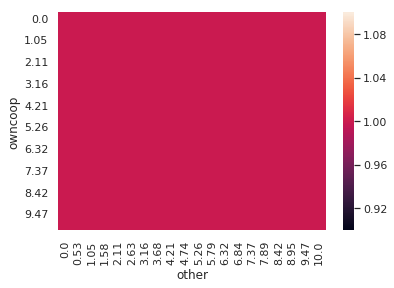

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_11/rep00/analysis_log_999.txt


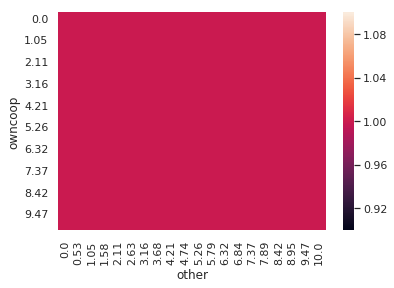

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_12/rep00/


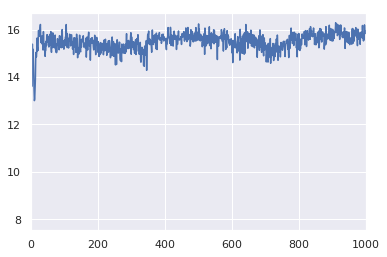

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_12/rep00/analysis_log_49.txt.gz


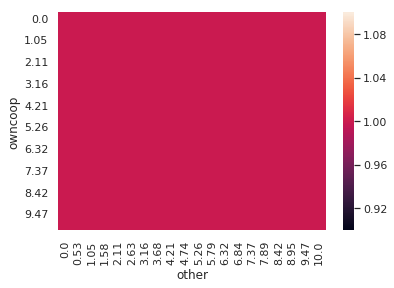

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_12/rep00/analysis_log_999.txt


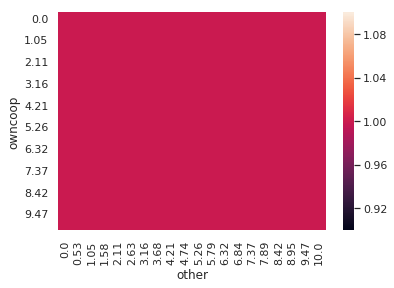

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_13/rep00/


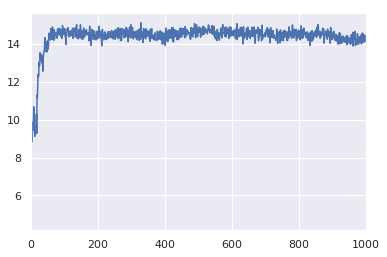

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_13/rep00/analysis_log_99.txt.gz


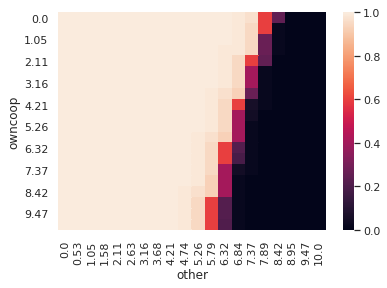

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_13/rep00/analysis_log_999.txt


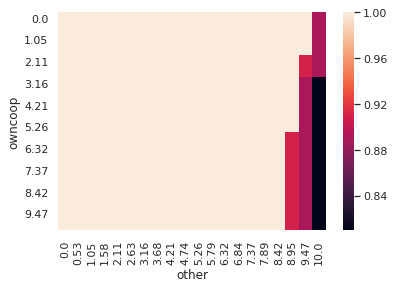

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_14/rep00/


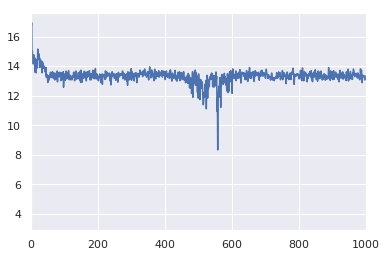

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_14/rep00/analysis_log_99.txt.gz


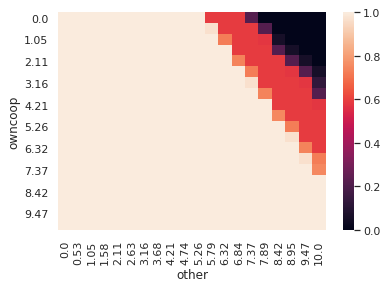

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_14/rep00/analysis_log_999.txt


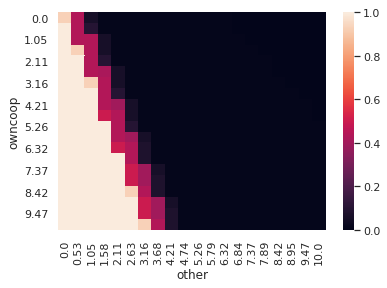

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_15/rep00/


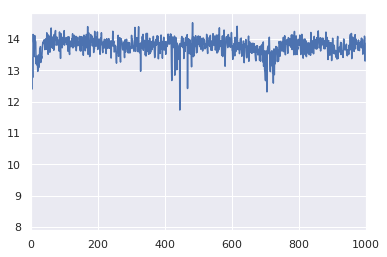

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_15/rep00/analysis_log_99.txt.gz


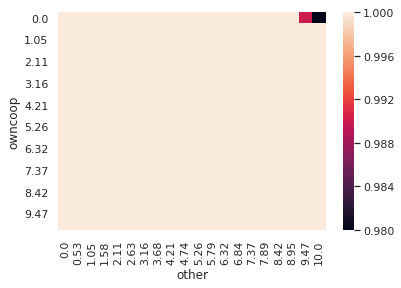

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_15/rep00/analysis_log_999.txt


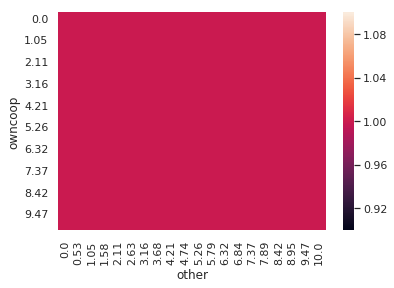

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_16/rep00/


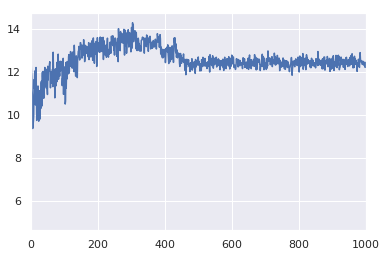

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_16/rep00/analysis_log_49.txt.gz


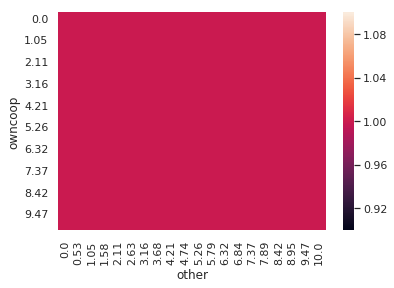

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_16/rep00/analysis_log_999.txt


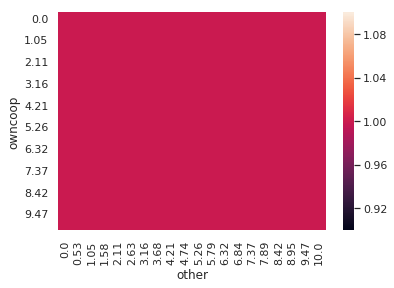

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_17/rep00/


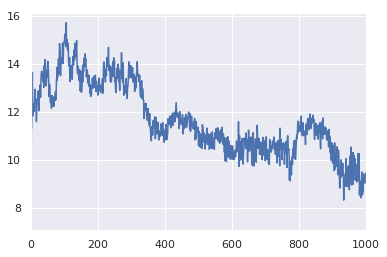

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_17/rep00/analysis_log_49.txt.gz


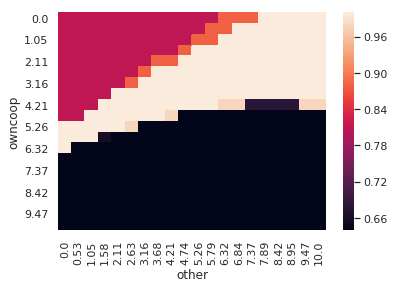

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_17/rep00/analysis_log_999.txt


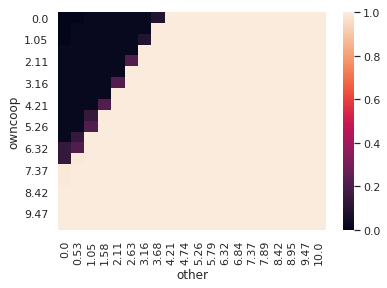

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_18/rep00/


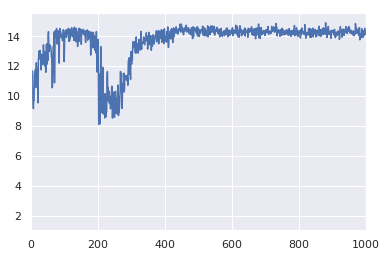

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_18/rep00/analysis_log_49.txt.gz


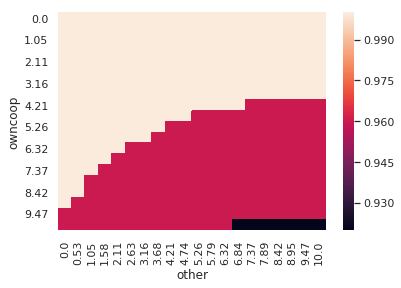

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_18/rep00/analysis_log_999.txt


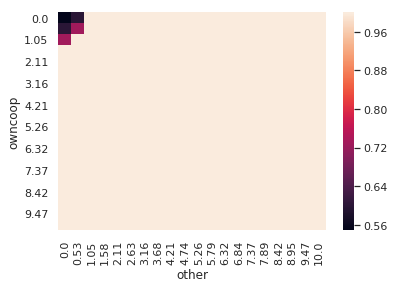

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_19/rep00/


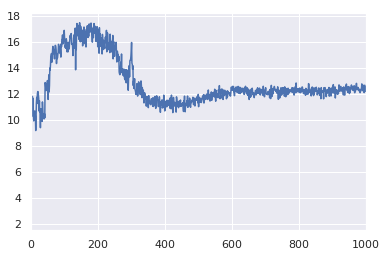

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_19/rep00/analysis_log_49.txt.gz


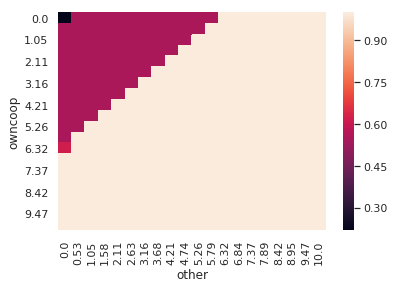

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_19/rep00/analysis_log_999.txt


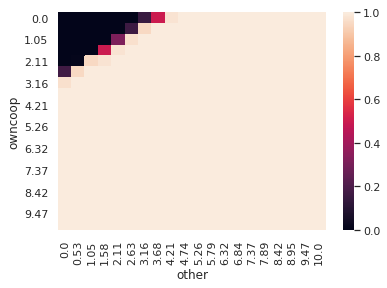

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_20/rep00/


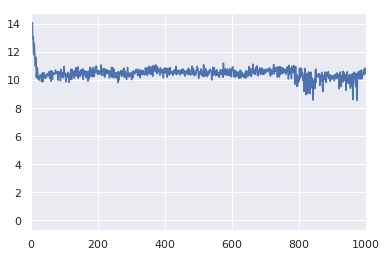

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_20/rep00/analysis_log_99.txt.gz


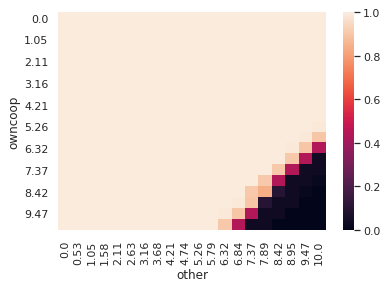

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_20/rep00/analysis_log_999.txt


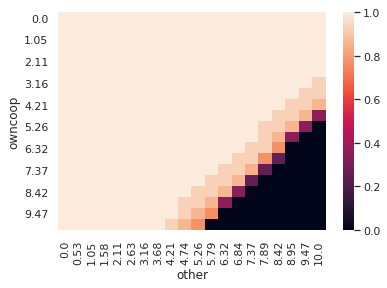

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_21/rep00/


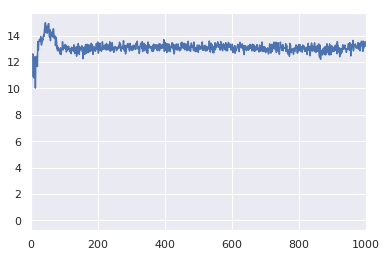

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_21/rep00/analysis_log_49.txt.gz


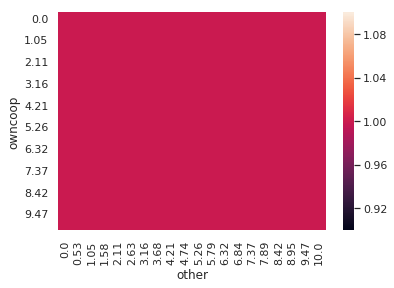

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_21/rep00/analysis_log_999.txt


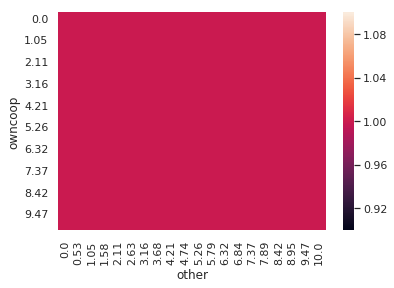

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_22/rep00/


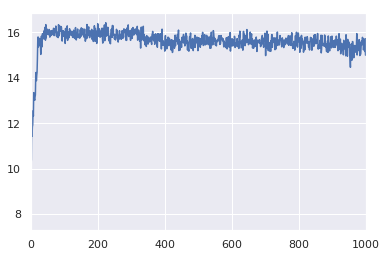

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_22/rep00/analysis_log_99.txt.gz


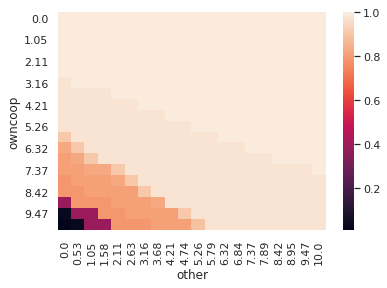

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_22/rep00/analysis_log_999.txt


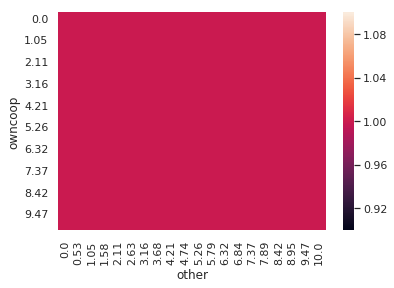

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_23/rep00/


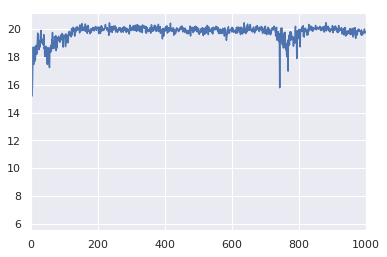

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_23/rep00/analysis_log_49.txt.gz


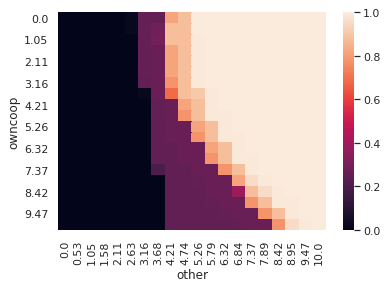

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_23/rep00/analysis_log_999.txt


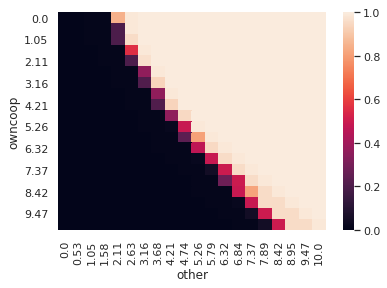

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_24/rep00/


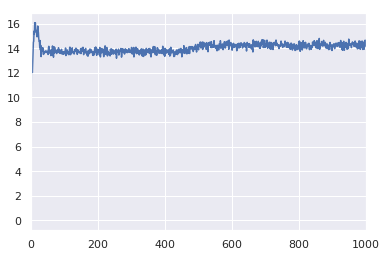

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_24/rep00/analysis_log_99.txt.gz


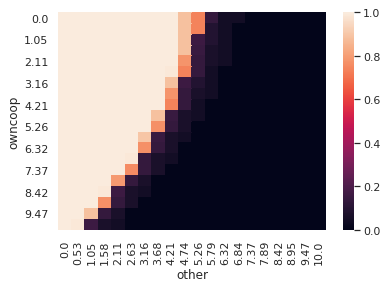

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue2-mutCoop0.01-uni0.001-2019-08-19-1540/run_24/rep00/analysis_log_999.txt


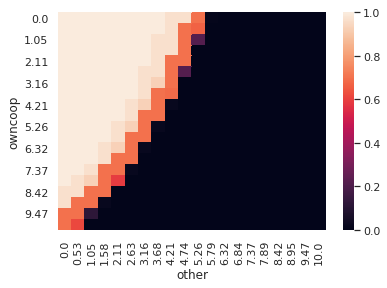

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_01/rep00/


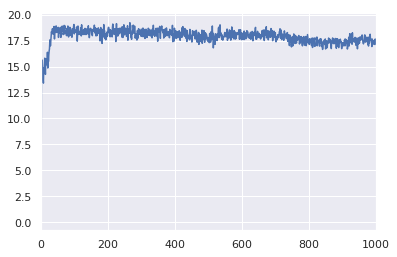

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_01/rep00/analysis_log_49.txt.gz


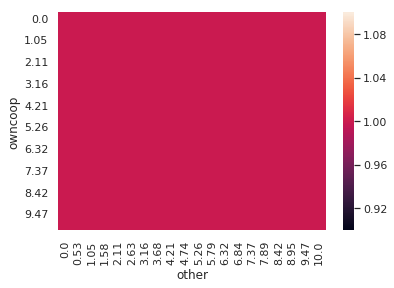

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_01/rep00/analysis_log_999.txt


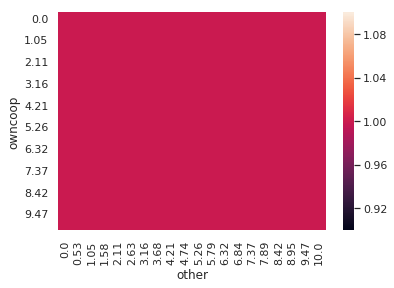

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_02/rep00/


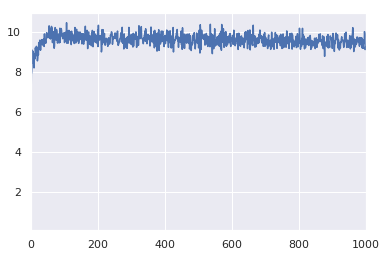

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_02/rep00/analysis_log_99.txt.gz


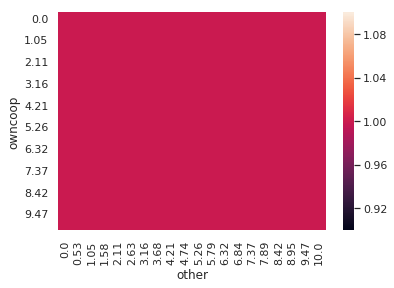

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_02/rep00/analysis_log_999.txt


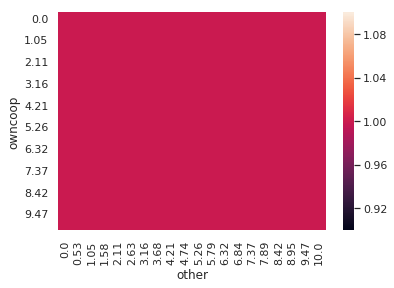

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_03/rep00/


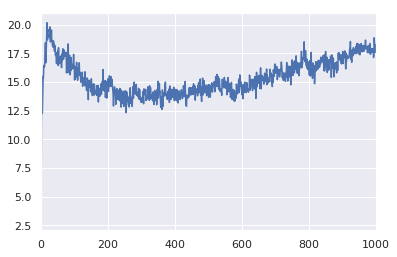

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_03/rep00/analysis_log_49.txt.gz


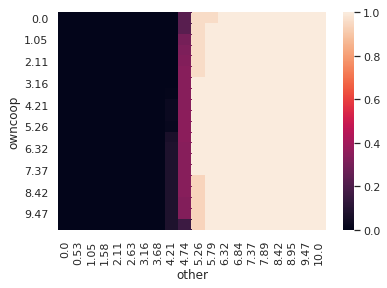

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_03/rep00/analysis_log_999.txt


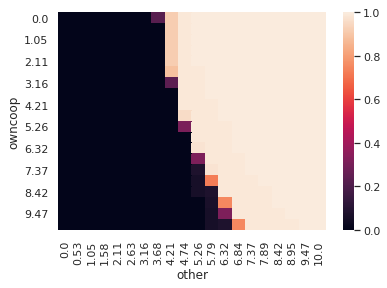

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_04/rep00/


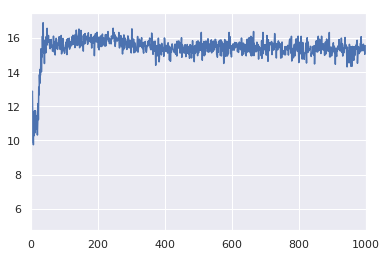

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_04/rep00/analysis_log_49.txt.gz


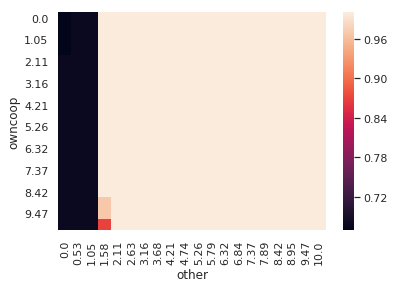

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_04/rep00/analysis_log_999.txt


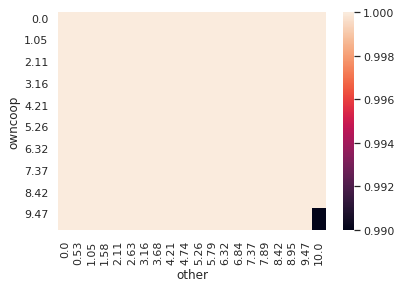

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_05/rep00/


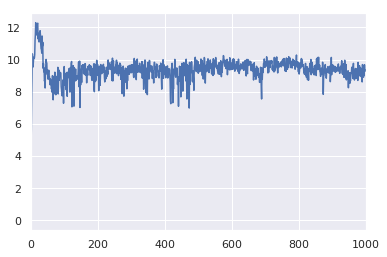

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_05/rep00/analysis_log_49.txt.gz


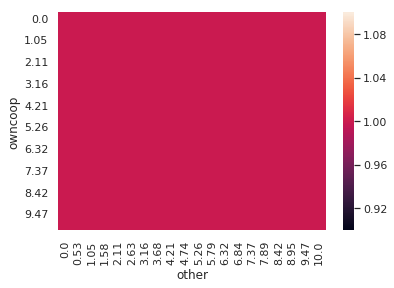

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_05/rep00/analysis_log_999.txt


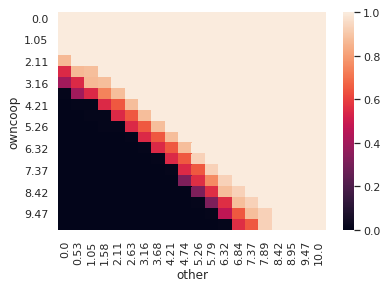

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_06/rep00/


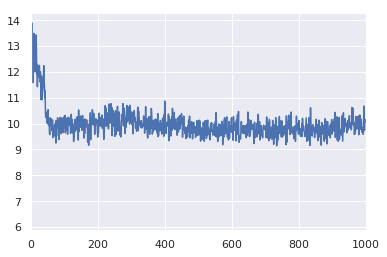

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_06/rep00/analysis_log_49.txt.gz


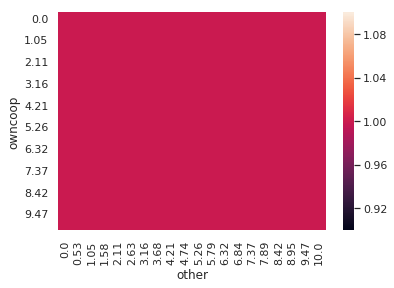

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_06/rep00/analysis_log_999.txt


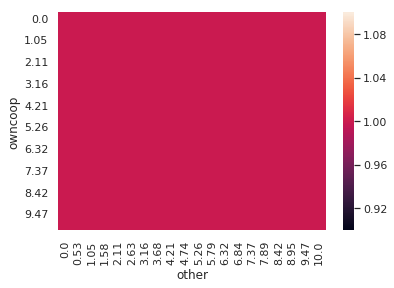

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_07/rep00/


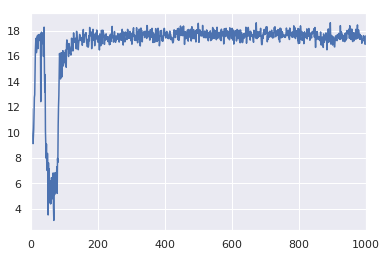

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_07/rep00/analysis_log_999.txt


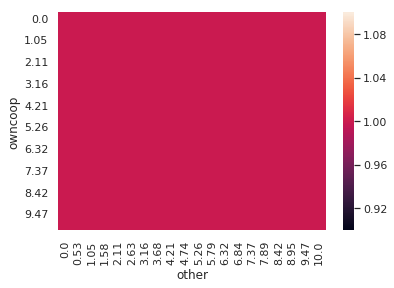

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_08/rep00/


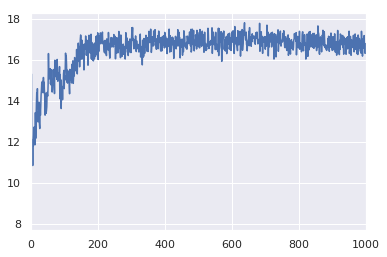

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_08/rep00/analysis_log_49.txt.gz


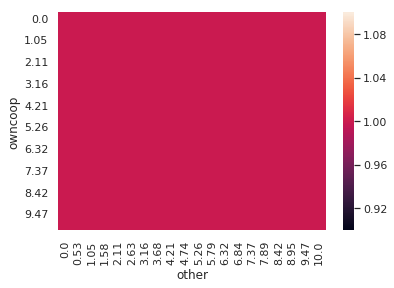

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_08/rep00/analysis_log_999.txt


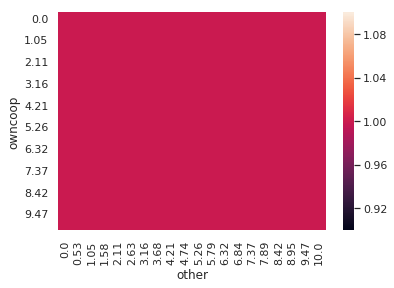

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_09/rep00/


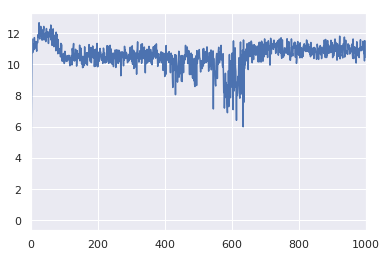

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_09/rep00/analysis_log_49.txt.gz


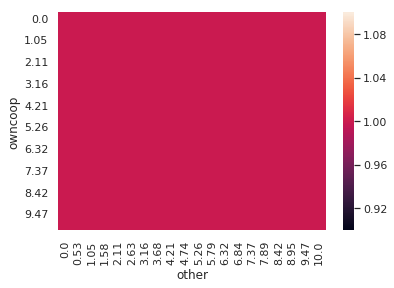

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_09/rep00/analysis_log_999.txt


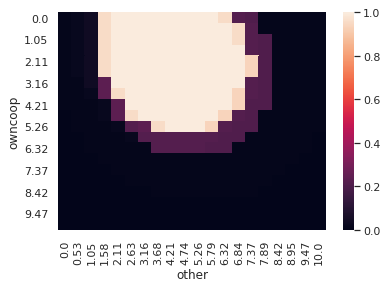

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_10/rep00/


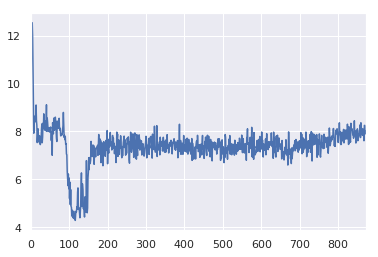

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_10/rep00/analysis_log_49.txt.gz


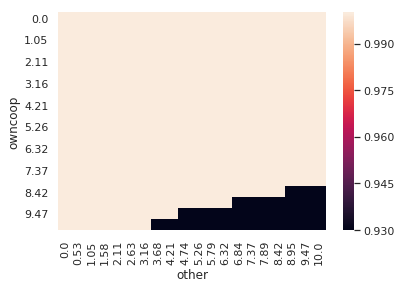

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_10/rep00/analysis_log_849.txt


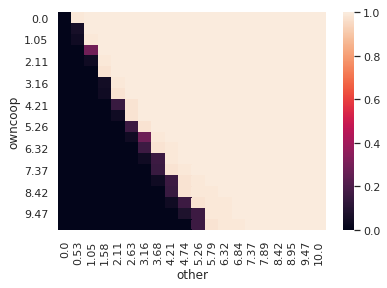

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_11/rep00/


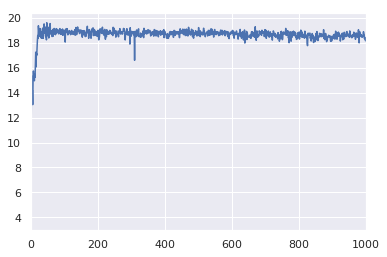

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_11/rep00/analysis_log_49.txt.gz


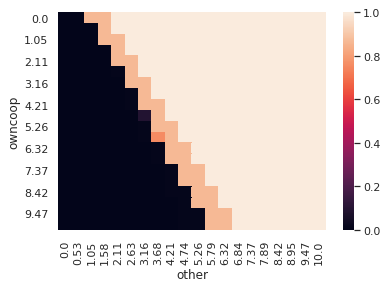

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_11/rep00/analysis_log_999.txt


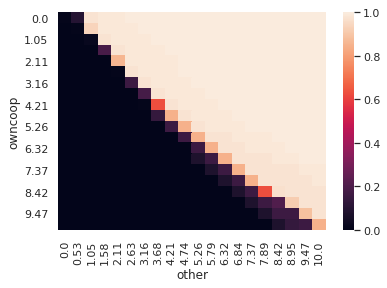

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_12/rep00/


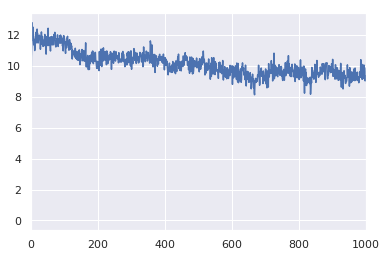

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_12/rep00/analysis_log_49.txt.gz


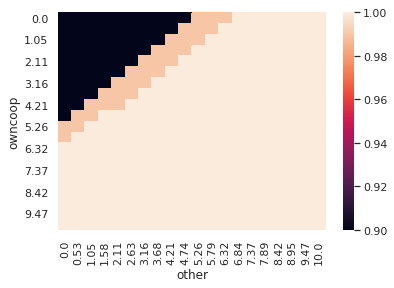

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_12/rep00/analysis_log_999.txt


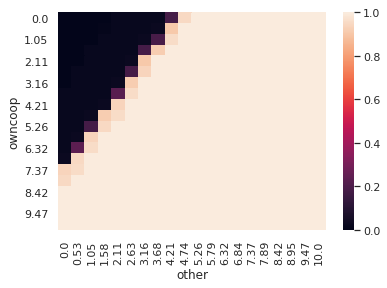

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_13/rep00/


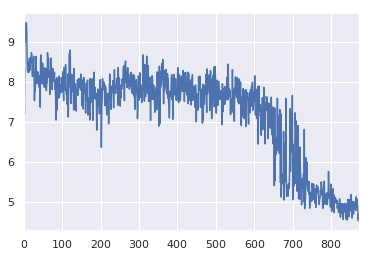

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_13/rep00/analysis_log_849.txt


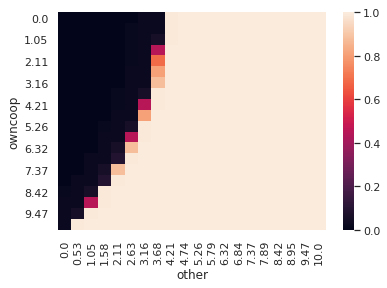

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_14/rep00/


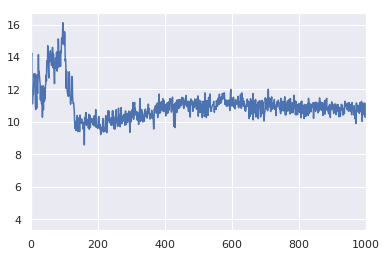

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_14/rep00/analysis_log_49.txt.gz


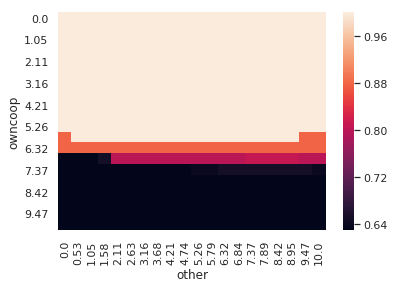

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_14/rep00/analysis_log_999.txt


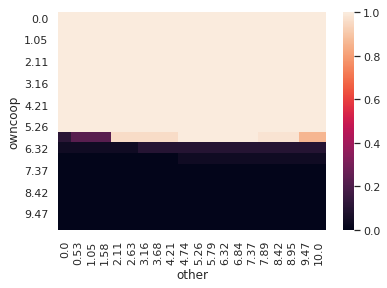

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_15/rep00/


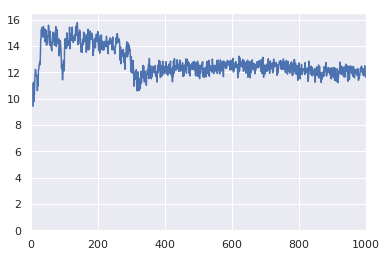

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_15/rep00/analysis_log_49.txt.gz


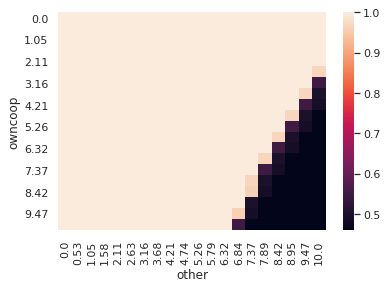

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_15/rep00/analysis_log_999.txt


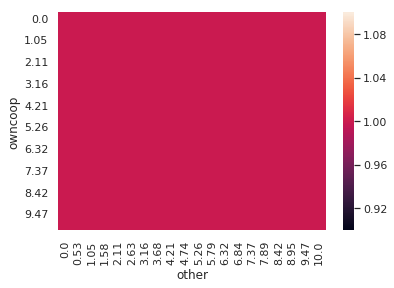

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_16/rep00/


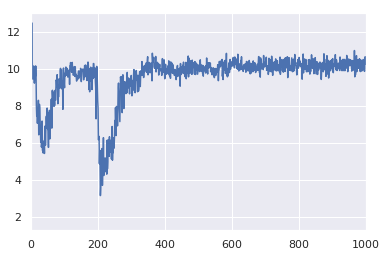

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_16/rep00/analysis_log_49.txt.gz


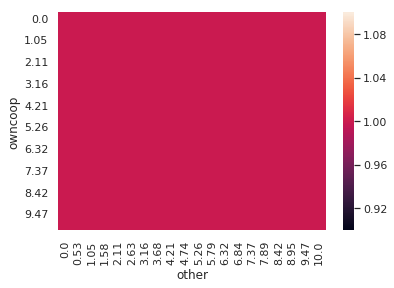

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_16/rep00/analysis_log_999.txt


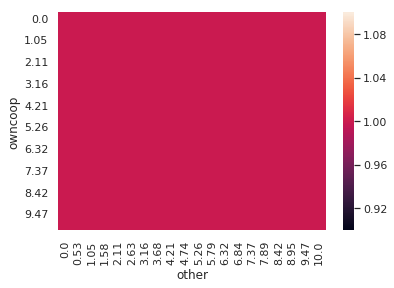

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_17/rep00/


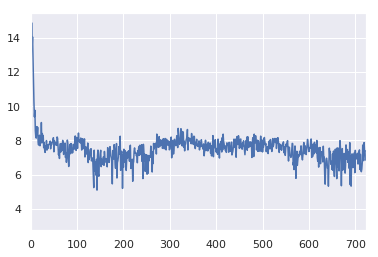

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_17/rep00/analysis_log_699.txt


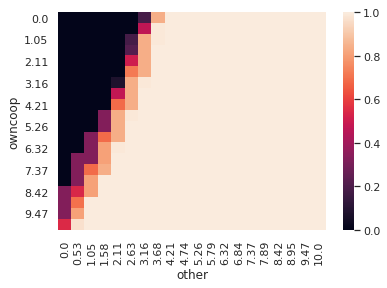

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_18/rep00/


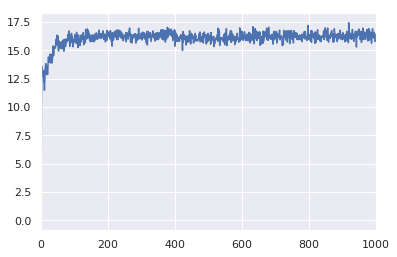

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_18/rep00/analysis_log_49.txt.gz


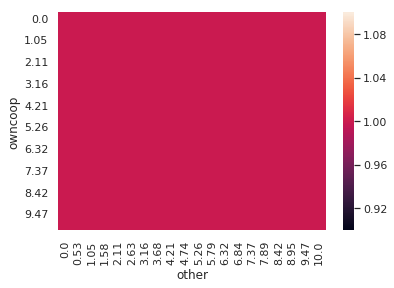

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_18/rep00/analysis_log_999.txt


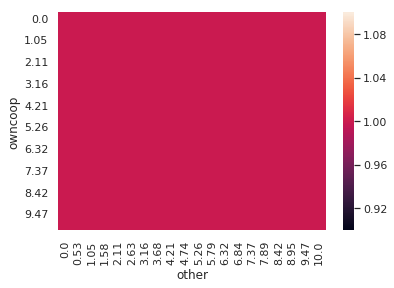

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_19/rep00/


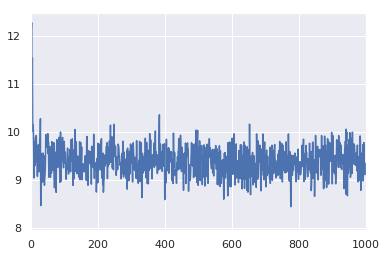

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_19/rep00/analysis_log_99.txt.gz


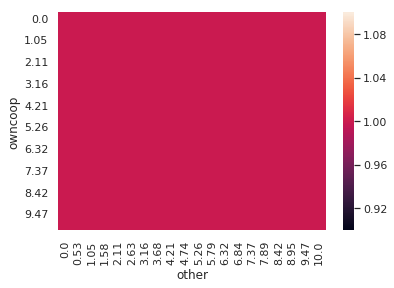

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_19/rep00/analysis_log_999.txt


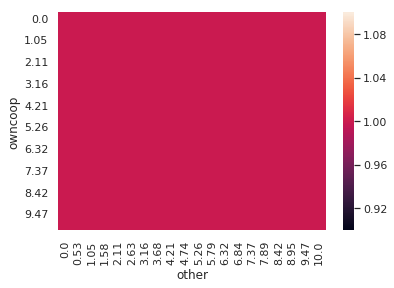

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_20/rep00/


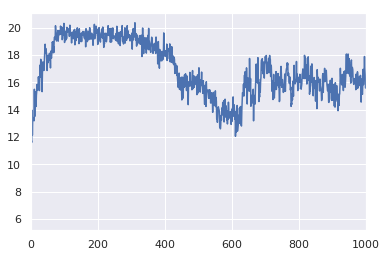

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_20/rep00/analysis_log_99.txt.gz


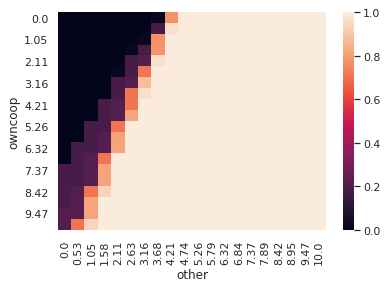

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_20/rep00/analysis_log_999.txt


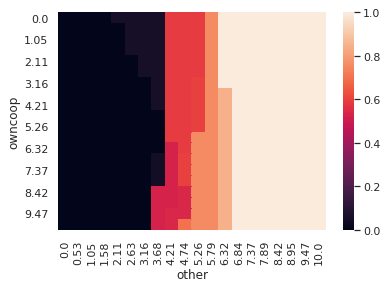

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_21/rep00/


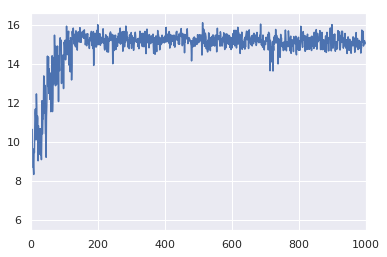

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_21/rep00/analysis_log_49.txt.gz


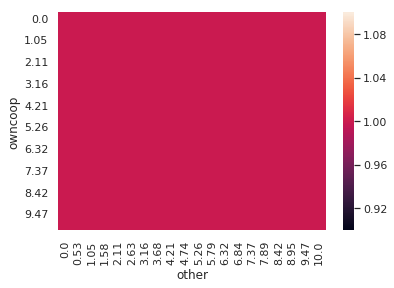

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_21/rep00/analysis_log_999.txt


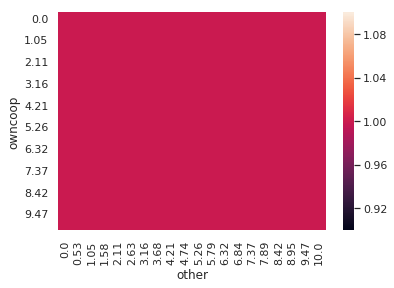

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_22/rep00/


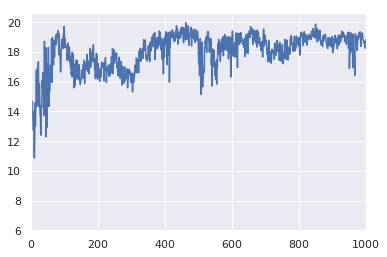

list index out of range
/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_22/rep00/analysis_log_999.txt


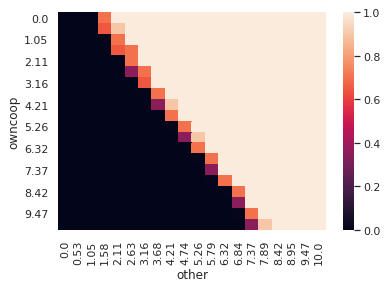

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_23/rep00/


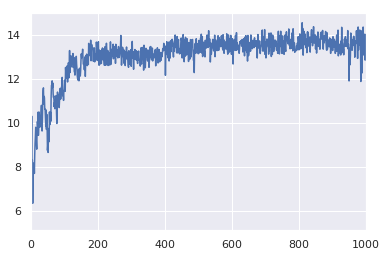

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_23/rep00/analysis_log_99.txt.gz


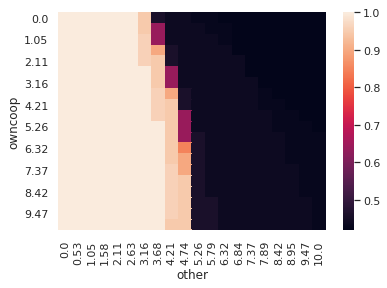

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_23/rep00/analysis_log_999.txt


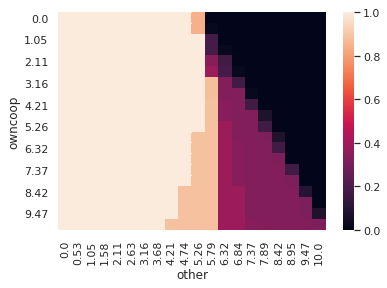

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_24/rep00/


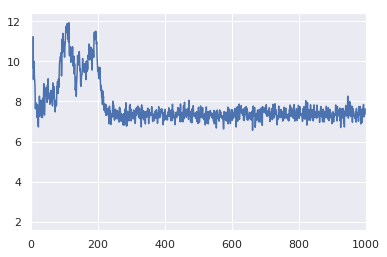

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_24/rep00/analysis_log_49.txt.gz


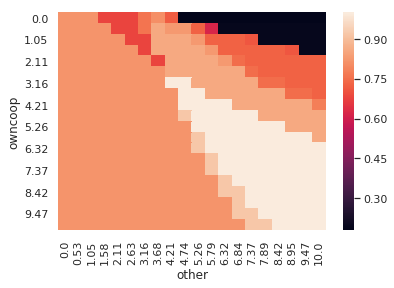

/home/pecoffet/remoterobo//logs/negociate2/negociate-fit-faketrue3-mutCoop0.01-uni0.001-2019-08-19-1540/run_24/rep00/analysis_log_999.txt


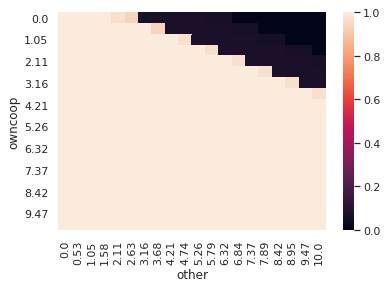

In [6]:
paths = sorted(glob.glob(f'{prefix}/logs/negociate2/**/rep00/', recursive=True))

for path in paths:
    print(path)
    try:
        fitness = read_csvx(path+'../fit.txt', delimiter="\t", names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
        fitness['med'].plot()
        plt.show()
        try:
            print(gethighest(glob.glob(path + '/analysis*'), 'analysis_log_', 2))
            choice = read_csvx(gethighest(glob.glob(path + '/analysis*'), 'analysis_log_', 2), delimiter="\t")
            choice['other'] = np.round(choice['other'], 2)
            choice['owncoop'] = np.round(choice['owncoop'], 2)
            sns.heatmap(pd.pivot_table(choice, 'accept', 'owncoop', 'other'))
            plt.show()
        except Exception as e:
            print(e)
        print(gethighest(glob.glob(path + '/analysis*'), 'analysis_log_'))
        choice = read_csvx(gethighest(glob.glob(path + '/analysis*'), 'analysis_log_'), delimiter="\t")
        choice['other'] = np.round(choice['other'], 2)
        choice['owncoop'] = np.round(choice['owncoop'], 2)
        sns.heatmap(pd.pivot_table(choice, 'accept', 'owncoop', 'other'))
        plt.show()

    except Exception as e:
        print(e)

In [7]:
glob.glob(f'/home/pecoffet/remoterobo//logs/negociate/negociate-faketrue-mutCoop0.1-2019-07-25-1854/negociate/o/mt_/run_14/rep00/*')

['/home/pecoffet/remoterobo//logs/negociate/negociate-faketrue-mutCoop0.1-2019-07-25-1854/negociate/o/mt_/run_14/rep00/datalog_20190725-18h54m14s932402us_5993.txt',
 '/home/pecoffet/remoterobo//logs/negociate/negociate-faketrue-mutCoop0.1-2019-07-25-1854/negociate/o/mt_/run_14/rep00/properties_20190725-18h54m14s932402us_5993.txt',
 '/home/pecoffet/remoterobo//logs/negociate/negociate-faketrue-mutCoop0.1-2019-07-25-1854/negociate/o/mt_/run_14/rep00/screenshots',
 '/home/pecoffet/remoterobo//logs/negociate/negociate-faketrue-mutCoop0.1-2019-07-25-1854/negociate/o/mt_/run_14/rep00/properties_20190805-17h14m10s858457us_5700.txt',
 '/home/pecoffet/remoterobo//logs/negociate/negociate-faketrue-mutCoop0.1-2019-07-25-1854/negociate/o/mt_/run_14/rep00/fitnesslog.txt',
 '/home/pecoffet/remoterobo//logs/negociate/negociate-faketrue-mutCoop0.1-2019-07-25-1854/negociate/o/mt_/run_14/rep00/properties_20190726-14h27m44s594374us_24038.txt',
 '/home/pecoffet/remoterobo//logs/negociate/negociate-faketru